In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import sys, os

##  Helper Functions

In [10]:

def convert_to_string(df, columns):
    for col in columns:
        df[col] = df[col].astype("string")


def convert_to_numbers(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col])


def convert_to_int(df, columns):
    for col in columns:
        df[col] = df[col].astype("int64")


def convert_to_datetime(df, columns):
    for col in columns:
        df[col] = pd.to_datetime(df[col])


def multiply_by_factor(df, columns, factor):
    for col in columns:
        df[col] = df[col] * factor


def percent_missing_values(df):

    # Calculate total number of cells in dataframe
    totalCells = np.product(df.shape)

    # Count number of missing values per column
    missingCount = df.isnull().sum()

    # Calculate total number of missing values
    totalMissing = missingCount.sum()

    # Calculate percentage of missing values
    print("The dataset contains", round(
        ((totalMissing/totalCells) * 100), 2), "%", "missing values.")


def percent_missing_rows(df):

    # Calculate total number rows with missing values
    missing_rows = sum([True for idx, row in df.iterrows() if any(row.isna())])

    # Calculate total number of rows
    total_rows = df.shape[0]

    # Calculate the percentage of missing rows
    print(round(((missing_rows/total_rows) * 100), 2), "%",
          "of the rows in the dataset contain atleast one missing value.")

# Function to calculate missing values by column


def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * mis_val / len(df)

    # dtype of missing values
    mis_val_dtype = df.dtypes

    # Make a table with the results
    mis_val_table = pd.concat(
        [mis_val, mis_val_percent, mis_val_dtype], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values', 2: 'Dtype'})

    # Sort the table by percentage of missing descending and remove columns with no missing values
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 0] != 0].sort_values(
        '% of Total Values', ascending=False).round(2)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    if mis_val_table_ren_columns.shape[0] == 0:
        return

    # Return the dataframe with missing information
    return mis_val_table_ren_columns


def fix_missing_ffill(df, col):
    count = df[col].isna().sum()
    df[col] = df[col].fillna(method='ffill')
    print(f"{count} missing values in the column {col} have been replaced using the forward fill method.")
    return df[col]


def fix_missing_bfill(df, col):
    count = df[col].isna().sum()
    df[col] = df[col].fillna(method='bfill')
    print(f"{count} missing values in the column {col} have been replaced using the backward fill method.")
    return df[col]


def fix_missing_median(df, col):
    median = df[col].median()
    count = df[col].isna().sum()
    df[col] = df[col].fillna(median)
    print(f"{count} missing values in the column {col} have been replaced by its median value {median}.")
    return df[col]


def fix_missing_value(df, col, value):
    count = df[col].isna().sum()
    df[col] = df[col].fillna(value)
    if type(value) == 'str':
        print(
            f"{count} missing values in the column {col} have been replaced by '{value}'.")
    else:
        print(
            f"{count} missing values in the column {col} have been replaced by {value}.")
    return df[col]


def drop_duplicates(df):
    old = df.shape[0]
    df.drop_duplicates(inplace=True)
    new = df.shape[0]
    count = old - new
    if (count == 0):
        print("No duplicate rows were found.")
    else:
        print(f"{count} duplicate rows were found and removed.")


def drop_rows_with_missing_values(df):
    old = df.shape[0]
    df.dropna(inplace=True)
    new = df.shape[0]
    count = old - new
    print(f"{count} rows containg missing values were dropped.")


def drop_columns(df, columns):
    df.drop(columns, axis=1, inplace=True)
    count = len(columns)
    if count == 1:
        print(f"{count} column was dropped.")
    else:
        print(f"{count} columns were dropped.")


In [4]:
# reading the csv file
missing_values = ["n/a", "na", "undefined"]
df = pd.read_csv("ABtwoCampaignEngView.csv",  na_values=missing_values)
df

,Unnamed: 0,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,1333639,8ec30aff-2332-4a1f-9330-b93abb32bc94,control,<built-in method date of Timestamp object at 0...,15,LG,156,6,0.0,0.0
1,730667,4e1bcb56-357c-4186-9d39-3be82e3519f1,control,<built-in method date of Timestamp object at 0...,7,Samsung,162,6,0.0,0.0
2,2069787,dd6ec327-fcfd-4a80-89c0-dccd3dd80f09,control,<built-in method date of Timestamp object at 0...,14,Apple,178,15,0.0,0.0
3,1692366,b5222d0f-39e3-4c02-a12f-1ef09d4f861f,control,<built-in method date of Timestamp object at 0...,22,Apple,167,15,0.0,0.0
4,1384123,9428377d-1504-4407-87c2-ce518f67eb87,control,<built-in method date of Timestamp object at 0...,21,Samsung,155,15,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
912707,1426994,98c10ba3-932f-4feb-ad01-d1b549dbd905,exposed,<built-in method date of Timestamp object at 0...,14,Samsung,162,15,0.0,1.0
912708,1846194,c591dcc1-2526-4caa-8561-0f9da1fe565b,exposed,<built-in method date of Timestamp object at 0...,8,Samsung,162,15,0.0,0.0
912709,2133458,e44046fa-0d3e-4680-99a8-f8d2167890f4,exposed,<built-in method date of Timestamp object at 0...,5,Apple,101,7,0.0,0.0
912710,1815799,c25657c2-f1b6-4f50-9610-9f3bbef2594d,exposed,<built-in method date of Timestamp object at 0...,14,Samsung,101,6,1.0,0.0


### General Statistics

In [6]:
# number of elements in the df
df.size

9127120

In [7]:
# rows and columns in the df
df.shape

(912712, 10)

In [8]:
# descriptive statistics that summarize the central tendency, dispersion of the df's numerical columns, excluding NaN values
df.describe()

,Unnamed: 0,hour,platform_os,browser,yes,no
count,9.127120e+05,912712.000000,912712.000000,912712.000000,912712.000000,912712.000000
mean,1.196268e+06,10.648142,127.813321,8.211051,0.101645,0.019499
std,6.900511e+05,7.372631,32.217674,3.536780,0.302182,0.138271
min,1.000000e+00,0.000000,101.000000,1.000000,0.000000,0.000000
25%,5.989198e+05,4.000000,101.000000,6.000000,0.000000,0.000000
50%,1.196384e+06,10.000000,101.000000,7.000000,0.000000,0.000000
75%,1.793652e+06,17.000000,162.000000,7.000000,0.000000,0.000000
max,2.391777e+06,23.000000,181.000000,15.000000,1.000000,1.000000


### Checking Missing Values

In [11]:
percent_missing_values(df)

The dataset contains 0.0 % missing values.


In [39]:
percent_missing_rows(df)

0.0 % of the rows in the dataset contain atleast one missing value.


### Unique Auction Id

In [15]:
# unique value counts
unique_counts = df['auction_id'].nunique()
unique_counts

892951

### Explore  Hour

In [17]:
# unique value counts
counts_df = df['hour'].value_counts()
counts_df

2     59428
3     56821
4     54899
0     54001
1     52635
23    46764
18    39889
20    39088
17    38876
19    37997
16    37816
5     36405
15    35944
6     35087
14    32615
21    32494
11    30566
12    29721
13    29248
10    28798
7     27911
9     26406
8     25397
22    23906
Name: hour, dtype: int64

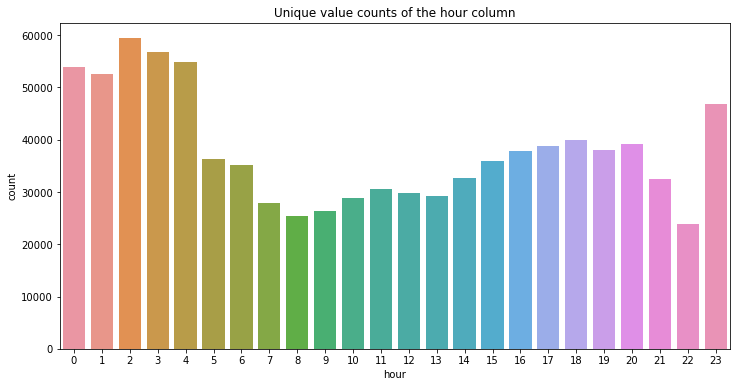

In [21]:
plt.figure(figsize=(12, 6))
plt.title('Unique value counts of the hour column')
sns.countplot(data=df, x='hour')
plt.show()

### Explore Experiment

In [19]:
# unique value counts
counts_df = df['experiment'].value_counts()
counts_df

exposed    456356
control    456356
Name: experiment, dtype: int64

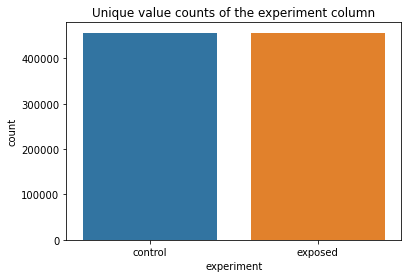

In [20]:
sns.countplot(data=df, x='experiment')
plt.title('Unique value counts of the experiment column');

### Explore Devices

In [22]:
# unique value counts
counts_df = df['device_make'].value_counts()
counts_df

Apple        474242
Samsung      285995
Google        75269
Motorola      26179
LG            20368
              ...  
unihertz          1
Alldocube         1
Lenco             1
ANS               1
Conquest          1
Name: device_make, Length: 255, dtype: int64

Total Unique Device

In [23]:
df['device_make'].nunique()

255

### Platform OS

In [25]:
# unique value counts
counts_df = df['platform_os'].value_counts()
counts_df

101    529469
162    118039
178     77651
156     48979
155     39381
        ...  
118         1
130         1
134         1
106         1
181         1
Name: platform_os, Length: 68, dtype: int64

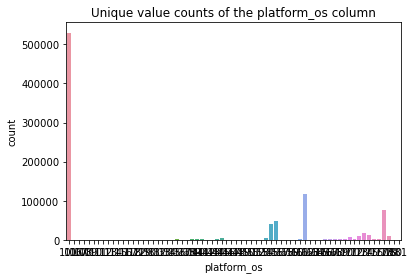

In [26]:
sns.countplot(data=df, x='platform_os')
plt.title('Unique value counts of the platform_os column');

### Explore Browser

In [27]:
# unique value counts
counts_df = df['browser'].value_counts()
counts_df

6     427413
7     289305
15    191935
5       2715
12       870
1        310
8        153
14         7
10         4
Name: browser, dtype: int64

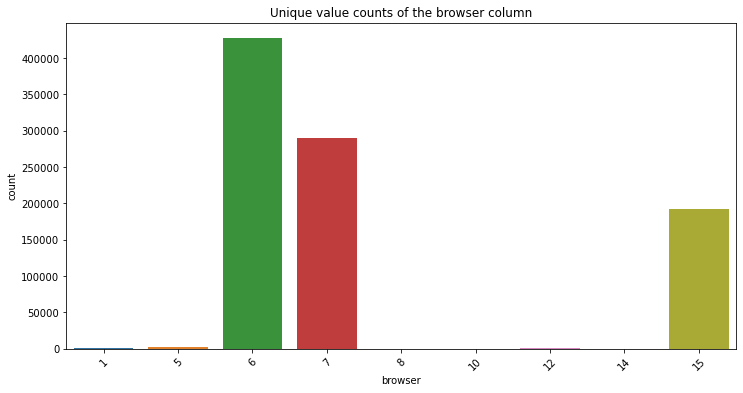

In [28]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="browser")
plt.title('Unique value counts of the browser column')
plt.xticks(rotation=45)
plt.show()

### Explore Yes

In [29]:
# unique value counts
counts_df = df['yes'].value_counts()
counts_df

0.0    819939
1.0     92773
Name: yes, dtype: int64

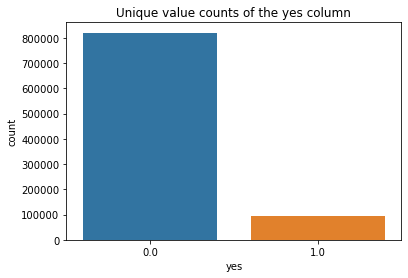

In [30]:
 sns.countplot(data=df, x="yes")
plt.title('Unique value counts of the yes column')
plt.show()

### Explore No

In [31]:
# unique value counts
counts_df = df['no'].value_counts()
counts_df

0.0    894915
1.0     17797
Name: no, dtype: int64

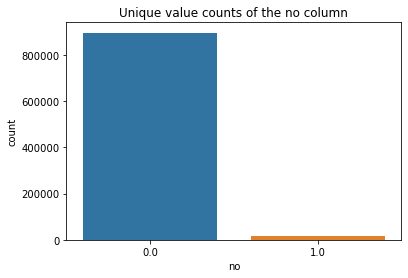

In [32]:
sns.countplot(data=df, x="no")
plt.title('Unique value counts of the no column')
plt.show()

## Comparing two Columns

### Experiment and Hour

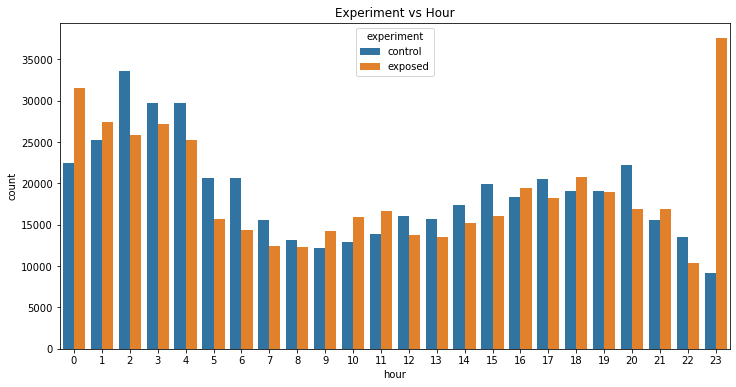

In [33]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="hour", hue="experiment")
plt.title('Experiment vs Hour')
plt.show()

### Experiment and Browser

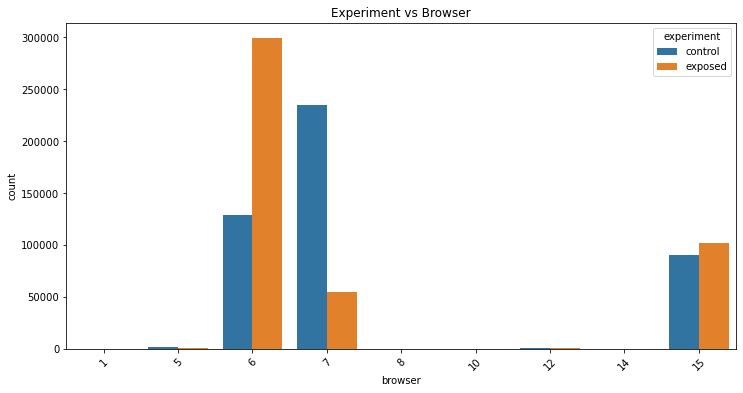

In [34]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="browser", hue="experiment")
plt.title('Experiment vs Browser')
plt.xticks(rotation=45)
plt.show()

### Experiment and OS

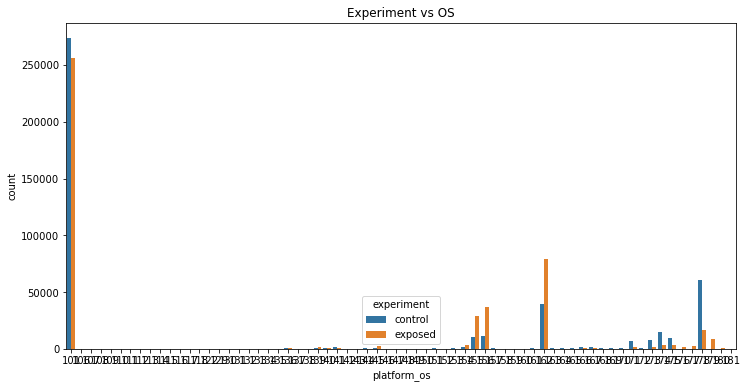

In [35]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="platform_os", hue="experiment")
plt.title('Experiment vs OS')
plt.show()

### Experiment and Yes

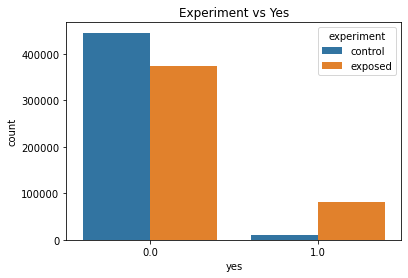

In [36]:
sns.countplot(data=df, x="yes", hue="experiment")
plt.title('Experiment vs Yes')
plt.show()

### Experiment and No

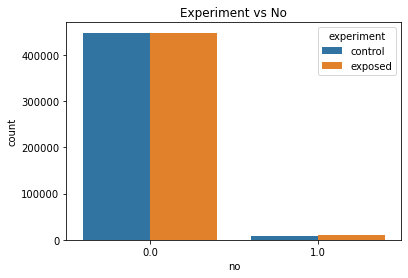

In [37]:
sns.countplot(data=df, x="no", hue="experiment")
plt.title('Experiment vs No')
plt.show()

## Correlation Analysis

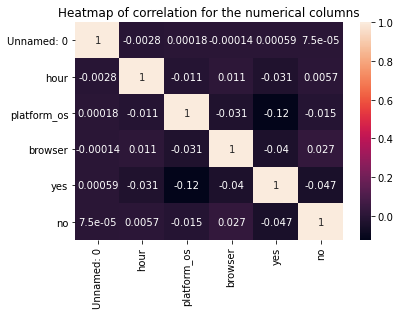

In [38]:
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.title('Heatmap of correlation for the numerical columns')
plt.show()